In [ ]:
 import pandas as pd
 import numpy as np
 import matplotlib.pyplot as plt
 from sklearn.preprocessing import MinMaxScaler
 from tensorflow.keras.layers import Dense,Dropout,LSTM
 from tensorflow.keras.models import Sequential
 import requests


In [ ]:
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv


In [ ]:
df=pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',parse_dates=['Date'],index_col=['Date'])
df.head(2)

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383


In [ ]:
#only want closing price for each day
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)':"Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()
timesteps[:5],prices[:5]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866]))

In [ ]:
import csv
import tensorflow as tf
from datetime import datetime

In [ ]:
timesteps=[]
btc_price = []
with open('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv','r') as f:
  csv_reader = csv.reader(f,delimiter=",")
  next(csv_reader) #skip first line (get rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1],"%Y-%m-%d")) # get the dates as date not string
    btc_price.append(float(line[2])) # get the closing price as float


In [ ]:
len(timesteps),len(btc_price)

(2787, 2787)

**making windows and labels**

In [ ]:
HORIZON = 1    # predict next 1 day
WINDOW_SIZE =7  #use the past week of btc data to make this prediction


In [ ]:
def get_labelled_window(x,horizon=HORIZON):
  return x[:,:-horizon],x[:,-horizon]


In [ ]:
#test out the window labeling function
test_window , test_label, = get_labelled_window(tf.expand_dims(tf.range(8),axis=0))
print(f"Window:{tf.squeeze(test_window).numpy()}->Label:{tf.squeeze(test_label).numpy()}")

Window:[0 1 2 3 4 5 6]->Label:7


In [ ]:
 #create a function to view numpy arrays as windows
 def make_windows(x,window_size = WINDOW_SIZE,horizon = HORIZON):
   """
   turns 1d array into 2d array of seq labbeled windows
   """
   windows_step = np.expand_dims(np.arange(window_size+horizon),axis=0)
   #create a 2d array of multiple windows
   window_indexes = windows_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis = 0).T
  #  print(f"window indexes:\n{window_indexes,window_indexes.shape}")

   #index on the target array with 2d array of multiple windows steps
   windowed_array=x[window_indexes]
   print(windowed_array)

   #get the labeled windows
   windows,labels = get_labelled_window(windowed_array,horizon=horizon)
   return windows, labels



In [ ]:
full_windows,full_labels = make_windows(prices,window_size = WINDOW_SIZE,horizon = HORIZON)
len(full_windows),len(full_labels)

[[  123.65499      125.455        108.58483    ...   120.65533
    121.795        123.033     ]
 [  125.455        108.58483      118.67466    ...   121.795
    123.033        124.049     ]
 [  108.58483      118.67466      121.33866    ...   123.033
    124.049        125.96116   ]
 ...
 [58788.20967893 58102.19142623 55715.54665129 ... 49764.1320816
  50032.69313676 47885.62525472]
 [58102.19142623 55715.54665129 56573.5554719  ... 50032.69313676
  47885.62525472 45604.61575361]
 [55715.54665129 56573.5554719  52147.82118698 ... 47885.62525472
  45604.61575361 43144.47129086]]


(2780, 2780)

In [ ]:
#view first 3 windows/labels
for i in range(3):
  print(f"Window:{full_windows[i]} -> Label {full_labels[i]}")

Window:[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label 123.033
Window:[125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label 124.049
Window:[108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label 125.96116


In [ ]:
#view first 3 windows/labels
for i in range(3):
  print(f"Window:{full_windows[i-3]} -> Label {full_labels[i-3]}")
  

Window:[58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label 47885.6252547166
Window:[58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label 45604.6157536131
Window:[55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label 43144.4712908603


In [ ]:
#make train/test splits
def make_train_test_splits(windows,labels,test_split=0.2):
   split_size = int(len(windows)*(1-test_split)) #this seperate data in 80 20 
   train_windows = windows[:split_size]
   train_labels = labels[:split_size] 
   test_windows = windows[split_size:]
   test_labels = labels[split_size:]

   return train_windows,test_windows,train_labels,test_labels


In [ ]:
#create train and test windows
train_windows , test_windows,train_labels,test_labels = make_train_test_splits(full_windows,full_labels)

In [ ]:
len(train_windows) , len(test_windows),len(train_labels),len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
train_windows[:2],train_labels[:2]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ]]), array([123.033, 124.049]))

In [ ]:
test_windows[:2],test_labels[:2]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463]]),
 array([8798.04205463, 9081.18687849]))

**creating a model checkpoint**

In [ ]:
import os
def create_model_checkpoint(model_name,save_path="model_experiment"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name),verbose=0,save_best_only=True)
  



#model 2 : DENSE(window = 30 horizon = 1)

In [ ]:
split_size = int(0.8*len(prices)) #80% train and 20% test 

X_train,y_train = timesteps [:split_size],prices[:split_size]
X_test,y_test = timesteps[split_size:],prices[split_size:]

In [ ]:
HORIZON = 1 #predict one step at time (one day of bitcoin prices )
WINDOW_SIZE  =30

In [ ]:
full_windows,full_labels = make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)

[[  123.65499      125.455        108.58483    ...   192.75666
    197.4          196.02499   ]
 [  125.455        108.58483      118.67466    ...   197.4
    196.02499      198.04883   ]
 [  108.58483      118.67466      121.33866    ...   196.02499
    198.04883      198.93233   ]
 ...
 [63346.78903511 61965.7825981  60574.44472823 ... 49764.1320816
  50032.69313676 47885.62525472]
 [61965.7825981  60574.44472823 56850.83016569 ... 50032.69313676
  47885.62525472 45604.61575361]
 [60574.44472823 56850.83016569 56224.10158771 ... 47885.62525472
  45604.61575361 43144.47129086]]


In [ ]:
len(full_windows),len(full_labels)

(2757, 2757)

In [ ]:
#making a train and testing windows
train_windows,test_windows,train_labels,test_labels = make_train_test_splits(windows=full_windows,
                                                                             labels=full_labels,
                                                                             test_split=0.2
                                                                             )
len(train_windows),len(train_labels),len(test_windows),len(test_labels)

(2205, 2205, 552, 552)

In [ ]:
train_windows[:1],train_labels[:1]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ]]),
 array([196.02499]))

In [ ]:
tf.random.set_seed(42)
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(1)
],name="model_1_dense")
model_1.compile(loss='mae',
                optimizer='adam',
                metrics=['mae'])
history = model_1.fit(train_windows,train_labels,epochs=100,batch_size = 128,validation_data = (test_windows,test_labels),callbacks= [create_model_checkpoint(model_name=model_1.name)])




In [ ]:
#eavaluate model on test data
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 658.0281 - mae: 658.0281


[658.028076171875, 658.028076171875]

In [ ]:
#load in the save best model_1 and evaluate it ontest data
model_2 = tf.keras.models.load_model("model_experiment/model_1_dense")
model_2.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 608.8478 - mae: 608.8478


[608.8478393554688, 608.8478393554688]

In [ ]:
#making forecast on the model
def make_preds(model,input_data):
   forecast = model.predict(input_data)
   return tf.squeeze(forecast) #return 1d array of prediction
   

In [ ]:
#get forecast prediction
model_2_preds = make_preds(model_2,input_data = test_windows)


18/18 [==============================] - 0s 3ms/step


In [ ]:
model_2_preds.shape

TensorShape([552])

In [ ]:
def mean_absolute_scaled_error(y_true,y_pred):
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))
  mae_naive_no_season=tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
  return mae/mae_naive_no_season

def evaluate_preds(y_true,y_pred):
  #make sure floar32 datatype
  y_true = tf.cast(y_true,dtype = tf.float32)
  y_pred = tf.cast(y_pred,dtype = tf.float32)

  #calcuate the various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse =tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mase=mean_absolute_scaled_error(y_true,y_pred)
  return{"mae":mae.numpy(),
          "mse":mse.numpy(),
          "rmse": rmse.numpy(),
          "mape":mape.numpy(),
           "mase":mase.numpy() }

In [ ]:
model_2_results = evaluate_preds(y_true=test_labels,y_pred = model_2_preds)
model_2_results

{'mae': 608.84796,
 'mse': 1284313.5,
 'rmse': 1133.2755,
 'mape': 2.7680647,
 'mase': 1.0642722}

In [ ]:
#creating a plot function
def plot_time_series(timesteps,values,format='.',start=0,end=None,label=None):
  """
  timesteps: array pf timestpes values
  values: array of values across time
  format: style of plot,defalult
  start: where to start the plot
  end: where to end the plot
  label : label to show on plot about values , defalut is none

  """
  plt.plot(timesteps[start:end],values[start:end],format,label=label)
  plt.xlabel("Time")
  plt.ylabel('Btc price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

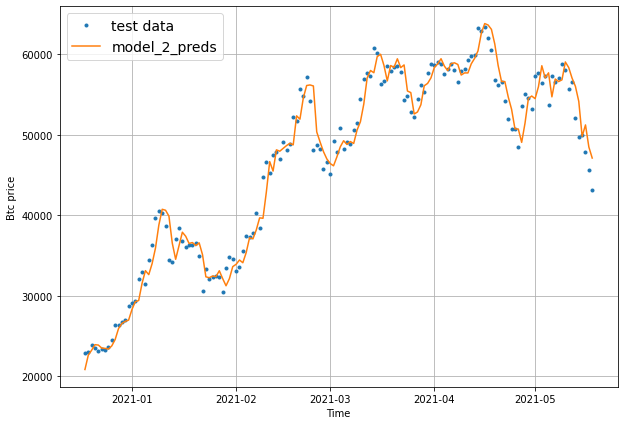

In [ ]:
offset = 400
plt.figure(figsize = (10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,],start=offset,label="test data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_2_preds,start=offset,format='-',label='model_2_preds')


#Model 3 DENSE(windows=30,horizon=7)

In [ ]:
HORIZON = 7 #predict one step at time (one day of bitcoin prices )
WINDOW_SIZE  =30

In [ ]:
full_windows,full_labels = make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)

[[  123.65499      125.455        108.58483    ...   210.3075
    225.02         248.25333   ]
 [  125.455        108.58483      118.67466    ...   225.02
    248.25333      262.32666   ]
 [  108.58483      118.67466      121.33866    ...   248.25333
    262.32666      294.48699   ]
 ...
 [58171.9090187  59295.95004401 59822.90167743 ... 49764.1320816
  50032.69313676 47885.62525472]
 [59295.95004401 59822.90167743 59853.19724227 ... 50032.69313676
  47885.62525472 45604.61575361]
 [59822.90167743 59853.19724227 63223.88439079 ... 47885.62525472
  45604.61575361 43144.47129086]]


In [ ]:
len(full_windows),len(full_labels)

(2751, 2751)

In [ ]:
train_windows,test_window,train_labels,test_labels=make_train_test_splits(windows=full_windows,
                                                                          labels=full_labels)
len( train_windows),len(test_window),len(train_labels),len(test_labels)                                                                         


(2200, 551, 2200, 551)

In [ ]:

tf.random.set_seed(42)
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(7)
],name="model_3_dense")
model_3.compile(loss='MAE',
                optimizer='adam',
                metrics=['mae'])
history_2 = model_3.fit(train_windows,
                        train_labels,
                        epochs=100,
                        batch_size = 128,
                        validation_data = (test_window,test_labels),
                        callbacks= [create_model_checkpoint(model_name=model_3.name)],
                        verbose=0)




In [ ]:
model_3.evaluate(test_window,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 609.4731 - mae: 609.4731


[609.4730834960938, 609.4730834960938]

In [ ]:
#load the best model
model_3 = tf.keras.models.load_model("model_experiment/model_3_dense")
model_3.evaluate(test_window,test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 602.0563 - mae: 602.0563


[602.0563354492188, 602.0563354492188]

In [ ]:
#make prediciton with model 3
model_3_preds = make_preds(model_3,input_data=test_window)
model_3_preds[:3]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[9188.418, 9269.789, 9398.374, 9311.184, 9303.162, 9319.819,
        9338.406],
       [8929.789, 8955.408, 9158.057, 8936.429, 8893.285, 8905.505,
        9016.58 ],
       [8947.181, 8820.201, 9038.075, 8844.681, 8775.781, 8752.289,
        8877.895]], dtype=float32)>

In [ ]:
model_2_preds[:3]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([8903.55 , 8932.77 , 8792.954], dtype=float32)>

In [ ]:
def evaluate_preds(y_true,y_pred):
  #make sure floar32 datatype
  y_true = tf.cast(y_true,dtype = tf.float32)
  y_pred = tf.cast(y_pred,dtype = tf.float32)

  #calcuate the various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse =tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mase=mean_absolute_scaled_error(y_true,y_pred)
  # if mae.ndim>0:
  #   mae = tf.reduce_mean(mae)
  #   mse = tf.reduce_mean(mse)
  #   rmse = tf.reduce_mean(rmse)
  #   mape = tf.reduce_mean(mape)
  #   mase = tf.reduce_mean(mase)
  return{"mae":mae.numpy(),
          "mse":mse.numpy(),
          "rmse": rmse.numpy(),
          "mape":mape.numpy(),
           "mase":mase.numpy() }

In [ ]:
model_3_pred = tf.reduce_mean(model_3_preds)
model_3_results = evaluate_preds(y_true=test_labels,y_pred=model_3_pred)
model_3_results

{'mae': 14182.255,
 'mse': 301476380.0,
 'rmse': 17363.076,
 'mape': 96.08799,
 'mase': 25.831463}

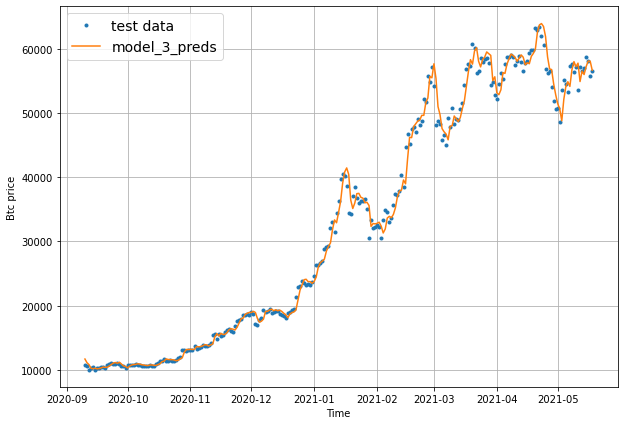

In [ ]:
offset = 300
plt.figure(figsize = (10,7))
plot_time_series(timesteps=X_test[-len(test_window):],values=test_labels[:,], start=offset, label="test data")
plot_time_series(timesteps=X_test[-len(test_window):],values=tf.reduce_mean(model_3_preds,axis=1),format='-', start=offset, label="model_3_preds")


#which of out model performed better

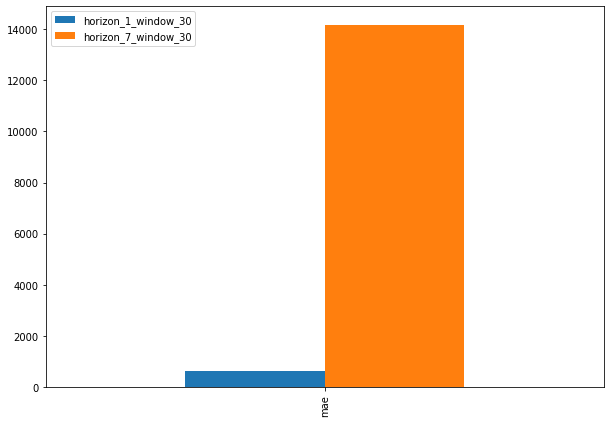

In [ ]:
 pd.DataFrame({
    "horizon_1_window_30":model_2_results,
    "horizon_7_window_30":model_3_results
 },
 index=['mae']
 ).plot(figsize = (10,7),kind='bar')